# Databao Feature Overview

Welcome! This notebook is a beginner‑friendly tour of Databao. You will:
- set up the environment and pick an LLM (cloud OpenAI or local Ollama)
- open a Databao session and register data sources plus helpful context
- ask questions with eager execution (default) and with lazy mode
- visualize results and generate short insight text
- learn advanced switches: disable thinking streaming, enable lazy mode, tweak row limits, and more

Notes:
- You need a DuckDB database at data/web_shop.duckdb (shipped with this example).
- Choose either OpenAI or local Ollama. If you use OpenAI, set your API key (OPENAI_API_KEY) in your environment.


In [2]:
# Quick installs (safe to re-run)
!pip install -q duckdb databao matplotlib pandas seaborn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.4/357.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/2

In [3]:
# Imports and DB connection
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Databao imports
import databao
from databao import LLMConfig
from databao.configs import LLMConfigDirectory

# Download and connect to the local DuckDB file.
!gdown https://drive.google.com/uc?id=16aN4_vFeIASKheAtlo8js3BS1NhrAdDU

DB_PATH = "web_shop.duckdb"
conn = duckdb.connect(DB_PATH, read_only=False)
print(f"Connected to DuckDB database: {DB_PATH}")


Downloading...
From: https://drive.google.com/uc?id=16aN4_vFeIASKheAtlo8js3BS1NhrAdDU
To: /content/web_shop.duckdb
100% 8.66M/8.66M [00:00<00:00, 30.9MB/s]
Connected to DuckDB database: web_shop.duckdb


## 1. Choose your LLM (cloud or local)

Option A — Cloud (OpenAI)
- Requires environment variable OPENAI_API_KEY to be set in your shell/Jupyter.
- Example (Jupyter only): `%env OPENAI_API_KEY=YOUR_OPENAI_API_KEY`

Option B — Local (Ollama)
- Install Ollama and start it (`ollama serve`).
- Pull a model, e.g. `ollama pull qwen3:8b` or similar.

We’ll default to a cloud config below, but you can switch to the local config by uncommenting one line.


### 1.1 Cloud setup

You need to fill in  your OpenAI api key into `OPENAI_API_KEY` environment variable

In [ ]:
# Option A — Cloud (OpenAI). Low temperature helps produce stable SQL/plots.
llm_config = LLMConfig(name="gpt-4.1-2025-04-14", temperature=0)

%env OPENAI_API_KEY=


### 1.1 Local setup

Uncomment cells below.

You don't have to edit anything, the cell below will download and setup a local Ollama instance on Colab compute. (approx 2 min of download/setup time)

In [4]:
!gdown https://drive.google.com/uc?id=1W_HuqVsj25lAI88zjE7jxWkj6A59-GFL
!unzip models_qwen3_8b.zip -d ollama_models
!curl https://ollama.ai/install.sh | sh

import os
import subprocess

OLLAMA_HOST = "127.0.0.1:1234"
os.environ["OLLAMA_HOST"] = OLLAMA_HOST
os.environ["OLLAMA_CONTEXT_LENGTH"] = "8192"
os.environ["OLLAMA_MODELS"] = "/content/ollama_models/models"
subprocess.Popen(["ollama", "serve"])

Downloading...
From (original): https://drive.google.com/uc?id=1W_HuqVsj25lAI88zjE7jxWkj6A59-GFL
From (redirected): https://drive.google.com/uc?id=1W_HuqVsj25lAI88zjE7jxWkj6A59-GFL&confirm=t&uuid=1d1719c4-1872-43bd-8f0b-276a3e824f3d
To: /content/models_qwen3_8b.zip
100% 5.56G/5.56G [00:32<00:00, 171MB/s]
Archive:  models_qwen3_8b.zip
   creating: ollama_models/models/
  inflating: ollama_models/__MACOSX/._models  
  inflating: ollama_models/models/.DS_Store  
  inflating: ollama_models/__MACOSX/models/._.DS_Store  
   creating: ollama_models/models/blobs/
  inflating: ollama_models/__MACOSX/models/._blobs  
   creating: ollama_models/models/manifests/
  inflating: ollama_models/__MACOSX/models/._manifests  
  inflating: ollama_models/models/blobs/sha256-b0830f4ff6a0220cfd995455206353b0ed23c0aee865218b154b7a75087b4e55  
  inflating: ollama_models/__MACOSX/models/blobs/._sha256-b0830f4ff6a0220cfd995455206353b0ed23c0aee865218b154b7a75087b4e55  
  inflating: ollama_models/models/blobs/sha2

<Popen: returncode: None args: ['ollama', 'serve']>

In [5]:
# Option B — Local (Ollama). This example defaults to local for easier setup.

llm_config = LLMConfigDirectory.QWEN3_8B_OLLAMA  # (Recommended) Use one of the preconfigured configs




## 2. Open a Databao session and add your data sources

We’ll register:
- a database connection (DuckDB)
- a small context file (to help the model navigate your schema)
- an example pandas DataFrame (also with a short context)
- a general, project‑wide context snippet via session.add_context()


In [6]:
session = databao.open_session(name="feature-overview", llm_config=llm_config)


# Register DuckDB with per‑source context (path to a markdown file is supported)
session.add_db(conn, context='context/duckdb_schema_overview.md')

# Also register an example DataFrame (not required, but shows how to add DFs)
cal = pd.DataFrame({
    "month": pd.date_range("2017-01-01", periods=6, freq="MS").strftime("%Y-%m"),
    "is_qtr_end": [False, False, True, False, False, True]
})

session.add_df(cal, name="calendar_helper", context="Small helper calendar with monthly rows and a qtr-end flag.")

# Add additional, project‑wide context (not tied to a specific source)
session.add_context(
    """
    Project‑wide notes:
    - Monetary values are in EUR unless stated otherwise.
    - When presenting dates, show them in YYYY‑MM-DD format.
    - Orders with status 'canceled' should be excluded from KPIs unless explicitly requested.
    """
)

print("Registered DBs:", list(session.dbs.keys()))
print("Registered DFs:", list(session.dfs.keys()))


Registered DBs: ['db1', 'duckdb']
Registered DFs: ['calendar_helper']


## 3. Start a thread — .ask() is eager by default

- By default, .ask(prompt) executes immediately (eager mode) and materializes results.
- You can change this behavior with lazy=True when creating a thread. We will demo lazy mode later.


In [7]:
thread = session.thread()  # eager by default

# Ask for a compact KPI table. In eager mode this executes immediately.
thread.ask(
    """
    Return a compact KPI table with:
    - orders_count
    - total_revenue
    - average_order_value
    """
)

In [8]:
# Access the already-materialized dataframe (cached in the thread)
df_kpis = thread.df()
df_kpis

======== <THINKING> ========

Okay, let's tackle this user query. The user wants a compact KPI table with orders_count, total_revenue, and average_order_value. 

First, I need to figure out how to calculate each of these metrics. 

Starting with orders_count. Since the user mentioned excluding canceled orders, I should check which tables have order status. The dim_orders table has order_status, so I'll need to filter out 'canceled' statuses. But wait, there's also the stg__orders table. Hmm, maybe the main.dim_orders is the correct one. Let me confirm. The main.dim_orders has order_status, and the raw.orders table also has it. But the user might be using the main schema. Wait, the context says to use the main schema. So I'll use main.dim_orders. But wait, the fct_sales table might have order_id linked to orders. Wait, maybe I should join the orders table with the sales to get the count of orders. Wait, no. The orders_count is just the number of orders, so I can count distinct order_id 

,orders_count,total_revenue,average_order_value
0,542,664673.8,1226.335424


In [9]:
# Peek at the generated SQL/code for transparency
print(thread.code())

SELECT COUNT(DISTINCT o.order_id) AS orders_count, SUM(p.payment_value) AS total_revenue, SUM(p.payment_value) / COUNT(DISTINCT o.order_id) AS average_order_value FROM main.dim_orders o JOIN main.fct_order_payments p ON o.order_id = p.order_id WHERE o.order_status != 'canceled';


## 4. Thread memory: follow-ups can reference earlier results

The same thread remembers context. Ask a related question and it will use the prior computation as needed.


In [ ]:
thread.ask("Add average delivery days and average review score to the KPI table. Keep it tidy.")
df_kpis_extended = thread.df()

======== <THINKING> ========

To add the requested KPIs, here’s the plan:

**Definitions:**
- average_delivery_days: The average number of days between order_purchased_at and order_delivered_to_customer_at, for non-canceled orders with a known delivery date.
- average_review_score: The average review_score for non-canceled orders with a review.

**Steps:**
1. Use dim_orders to calculate delivery days (order_delivered_to_customer_at - order_purchased_at) for each order.
2. Join with dim_order_reviews to get review scores.
3. Join with fct_sales for revenue and order count as before.
4. Aggregate all metrics in a single query, ensuring only non-canceled orders are included.

Now, I will run the query to produce a compact KPI table.

[tool_call: 'run_sql_query']
```
{"sql":"SELECT \n    COUNT(DISTINCT o.order_id) AS orders_count,\n    SUM(s.item_price) AS total_revenue,\n    CASE WHEN COUNT(DISTINCT o.order_id) = 0 THEN NULL ELSE SUM(s.item_price) / COUNT(DISTINCT o.order_id) END AS avera

In [ ]:
df_kpis_extended

,orders_count,total_revenue,average_order_value,average_delivery_days,average_review_score
0,542,635836.36,1173.129815,10 days 04:15:28.155384,3.503778


## 5. Chaining with lazy mode: .ask().ask().ask()

In lazy mode you can refine the same request by chaining .ask() calls; nothing is computed
until you materialize with .df(), .plot(), .text(), or .code().

Tip: Use a new thread for topics that don’t build on previous context.


In [ ]:
lazy_thread = session.thread(lazy=True)  # turn lazy mode on for this thread
(
    lazy_thread
        .ask("Compute monthly revenue for the last 6 months.")
        .ask("Include a 2-month moving average.")
        .ask("Name the columns month, revenue, revenue_ma2.")
)


Unmaterialized Pipe.

In [ ]:
df_trend = lazy_thread.df()

======== <THINKING> ========

To answer your question, here’s the step-by-step plan:

1. **Define Revenue**: Revenue is typically the sum of all payments received for completed (non-canceled) orders. We'll use the `fct_order_payments` table, which records payment values per order.
2. **Filter for Last 6 Months**: We'll consider the last 6 full months up to today (2025-11-12), so from 2025-05-01 to 2025-10-31.
3. **Exclude Canceled Orders**: We'll join with the `dim_orders` table to exclude orders with status 'canceled'.
4. **Aggregate by Month**: We'll group the results by year and month.

Let’s proceed to run the query.

[tool_call: 'run_sql_query']
```
{"sql":"SELECT\n  strftime('%Y-%m', fop.order_purchased_at) AS year_month,\n  SUM(fop.payment_value) AS revenue\nFROM web_shop.main.fct_order_payments fop\nJOIN web_shop.main.dim_orders o ON fop.order_id = o.order_id\nWHERE o.order_status != 'canceled'\n  AND fop.order_purchased_at >= date_trunc('month', date '2025-11-12') - INTERVAL '

In [ ]:
# Quick visualization
lazy_thread.plot("Line chart of revenue and revenue_ma2 by month")


VegaChatResult(text='<explain>\nNo filters are needed because the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This allows for easy comparison of the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two lines.\n</explain>\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "line",\n  "encoding": {\n    "x": {\n      "field": "month",\n      "type": "temporal"\n    },\n    "y": {\n      "field": "value",\n      "type": "quantitative"\n    },\n    "color": {\n      "field": "variable",\n      "type": "nominal",\n      "title": "Metric"\n    }\n  },\n  "transform": [\n    {\n      "fold": ["revenue", "revenue_ma2"],\n      "as": ["variable", "value"]\n    }\n  ]\n}\n</json>\n', meta={'message': AIMessage(content=[{'type': 'text', 'text': '<explain>\nNo filters are needed because the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This allows for easy comparison of the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two lines.\n</explain>\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "line",\n  "encoding": {\n    "x": {\n      "field": "month",\n      "type": "temporal"\n    },\n    "y": {\n      "field": "value",\n      "type": "quantitative"\n    },\n    "color": {\n      "field": "variable",\n      "type": "nominal",\n      "title": "Metric"\n    }\n  },\n  "transform": [\n    {\n      "fold": ["revenue", "revenue_ma2"],\n      "as": ["variable", "value"]\n    }\n  ]\n}\n</json>\n', 'annotations': []}], additional_kwargs={}, response_metadata={'id': 'resp_0336d29bb788db6d016914e2c6c6b481958f77a820e28c492f', 'created_at': 1762976454.0, 'metadata': {}, 'model': 'gpt-4.1-2025-04-14', 'object': 'response', 'service_tier': 'default', 'status': 'completed', 'model_name': 'gpt-4.1-2025-04-14'}, id='msg_0336d29bb788db6d016914e2c7440481959d69a998fcf4cd40', usage_metadata={'input_tokens': 1058, 'output_tokens': 258, 'total_tokens': 1316, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}), 'message_type': <MessageType.AI_RESPONSE_VALID: 'ai_response'>, 'spec': {'$schema': 'https://vega.github.io/schema/vega-lite/v5.json', 'mark': 'line', 'encoding': {'x': {'field': 'month', 'type': 'temporal'}, 'y': {'field': 'value', 'type': 'quantitative'}, 'color': {'field': 'variable', 'type': 'nominal', 'title': 'Metric'}}, 'transform': [{'fold': ['revenue', 'revenue_ma2'], 'as': ['variable', 'value']}]}, 'is_spec_fixed': False, 'is_empty_chart': False, 'is_valid_schema': True, 'is_drawable': True, 'model_response': {'specs': [{'$schema': 'https://vega.github.io/schema/vega-lite/v5.json', 'mark': 'line', 'encoding': {'x': {'field': 'month', 'type': 'temporal'}, 'y': {'field': 'value', 'type': 'quantitative'}, 'color': {'field': 'variable', 'type': 'nominal', 'title': 'Metric'}}, 'transform': [{'fold': ['revenue', 'revenue_ma2'], 'as': ['variable', 'value']}]}], 'explanation': 'No filters are needed because the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This allows for easy comparison of the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two

## 6. Insights: ask for a short narrative and read it via .text()


In [ ]:
# We're setting stream=False to
lazy_thread.ask("Write 3 bullet insights about the revenue trend you just computed. Keep it concise.", stream=False)
print(lazy_thread.text())


- Revenue reached its highest point in July 2025, then declined in August before partially recovering in September.
- The 2-month moving average shows a downward trend after July, indicating a softening in sales momentum.
- Monthly revenue fluctuations are moderate, with no extreme drops or spikes over the observed period.


## 7. Use the DataFrame yourself (pandas / seaborn)

The DataFrame returned by .df() is just a normal pandas DataFrame. You can use it anywhere.


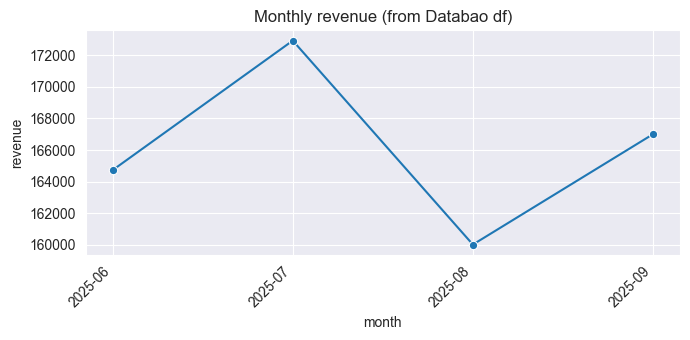

In [ ]:
if {"month", "revenue"}.issubset(df_trend.columns):
    plt.figure(figsize=(7, 3.5))
    sns.lineplot(data=df_trend, x="month", y="revenue", marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.title("Monthly revenue (from Databao df)")
    plt.tight_layout()
    plt.show()
else:
    print("df_trend columns:", df_trend.columns.tolist(), "— adjust the plotting code to your column names.")


## 8. Advanced features you can toggle

- Disable streaming of model tokens (cleaner output)
- Make .ask() lazy
- Adjust row limits

Examples below show per‑thread and per‑call control.


In [ ]:
# A) Disable streaming for a whole thread (eager, but no token‑by‑token streaming)
no_stream = session.thread(stream_ask=False)
no_stream.ask("Compute the top 5 products by revenue last month.")
df_top5 = no_stream.df()
df_top5.head()


,product_id,product_category,total_revenue
0,8efe1caed4e9e8bf475630c46b8108d2,Furniture & Decor,7951.90
1,6fee3c3366b596ecfae722087b1a58c7,Computers,7947.67
2,be8885ca8134dcc3fbaeda9a9c221354,Musical Instruments,6922.04
3,de22fdfd78bc93ae0c912af529e87f6f,Musical Instruments,6655.86
4,6fbd72e951ce3a8294ce341cd848f6a2,Furniture & Decor,6610.61


In [ ]:
# B) Disable streaming per ask on an existing thread
thread.ask("Now compute total orders by country.", stream=False)
orders_by_country = thread.df()
orders_by_country.head()


In [ ]:
# С) Make future threads lazy by default for a new session (change-wide default)
# (Uncomment to create a new session configured for lazy threads by default)
# lazy_session = databao.open_session(
#     name="feature-overview-lazy",
#     llm_config=llm_config,
#     default_lazy_threads=True,
# )
# lazy_session.thread().ask("This won't run until you call .df() because lazy is now the default.")


In [ ]:
# E) Adjust row limits on materialization
small_sample = session.thread(lazy=False)
small_sample.ask("Return all raw orders rows", rows_limit=1)


======== <THINKING> ========



[tool_call: 'run_sql_query']
```
{"sql":"SELECT * FROM web_shop.raw.orders"}
```


```sql
SELECT * FROM web_shop.raw.orders
```


[tool_call_output: 'run_sql_query']
```
query_id='2-0'

order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
ord_0001,cust_0001,shipped,2025-08-31 11:26:00,2025-08-31 12:47:00,2025-09-04 02:26:00,,2025-09-12 11:26:00
ord_0002,cust_0002,invoiced,2025-09-08 19:19:00,2025-09-08 21:54:00,,,2025-09-14 19:19:00
ord_0003,cust_0003,invoiced,2025-06-10 04:42:00,2025-06-10 05:59:00,,,2025-06-29 04:42:00
ord_0004,cust_0004,delivered,2025-08-12 01:23:00,2025-08-12 01:52:00,2025-08-14 13:23:00,2025-08-21 20:23:00,2025-08-20 01:23:00
ord_0005,cust_0005,canceled,2025-09-01 16:01:00,2025-09-01 16:21:00,,,2025-09-11 16:01:00
ord_0006,cust_0006,delivered,2025-08-18 10:08:00,2025-08-18 10:41:00,2025-08-21 13:08:00,2025-08-25 17:08:00,

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,ord_0001,cust_0001,shipped,2025-08-31 11:26:00,2025-08-31 12:47:00,2025-09-04 02:26:00,NaT,2025-09-12 11:26:00
1,ord_0002,cust_0002,invoiced,2025-09-08 19:19:00,2025-09-08 21:54:00,NaT,NaT,2025-09-14 19:19:00
2,ord_0003,cust_0003,invoiced,2025-06-10 04:42:00,2025-06-10 05:59:00,NaT,NaT,2025-06-29 04:42:00
3,ord_0004,cust_0004,delivered,2025-08-12 01:23:00,2025-08-12 01:52:00,2025-08-14 13:23:00,2025-08-21 20:23:00,2025-08-20 01:23:00
4,ord_0005,cust_0005,canceled,2025-09-01 16:01:00,2025-09-01 16:21:00,NaT,NaT,2025-09-11 16:01:00
...,...,...,...,...,...,...,...,...
595,ord_0596,cust_0196,delivered,2025-07-09 09:20:00,2025-07-09 10:07:00,2025-07-11 16:20:00,2025-07-24 13:20:00,2025-07-29 09:20:00
596,ord_0597,cust_0197,delivered,2025-09-19 11:12:00,2025-09-19 11:45:00,2025-09-22 04:12:00,2025-09-29 17:12:00,2025-10-05 11:12:00
597,ord_0598,cust_0198,delivered,2025-07-03 06:21:00,2025-07-03 09:03:00,2025-07-05 01:21:00,2025-07-11 04:21:00,2025-07-21 06:21:00
598,ord_0599,cust_0199,delivered,2025-06-22 01:44:00,2025-06-22 02:22:00,2025-06-22 04:44:00,2025-07-03 19:44:00,2025-07-07 01:44:00


In [ ]:
# Close the database connection when done
conn.close()
print("Database connection closed successfully!")


Database connection closed successfully!
